# Generate Audio for Behavior Task

## Initial setup

In [2]:
import wave, struct, math
import numpy as np
from scipy import signal
import os, json
import matplotlib.pyplot as plt

In [3]:
output_dir = os.getcwd()
print(output_dir)

/home/ckemere/Code/TreadmillIO/ClientSide/Sounds


## Generate frequency modulated tone stimulus where pitch oscillates as sinewave when plotted on a log scale

Specifically, instantaneous $\phi(t) = f_c \cdot 2^{(B/2) \cdot \sin(2 \pi f_m t)}$, where $f_c$ is the fundamental pitch, $f_m$ is the modulation frequency, and $B$ is the bandwidth of the oscillations in octaves. $B=2$ implies the frequency shifts by 2 octaves from the carrier. A frequency-modulated (FM) signal with a continuous phase function can be written as $\sin(\int \phi(t) dt)$ (the indefinite integral of the phase function). Unfortunately, for the log-sine stimulus, the indefinite integral involves infinite sums and bessel functions, etc., which effectively means it has to be computed. Taking the easier way out, we will interpolate it using a cubic spline.

One side effect of the lack of a simple closed form solution is that it not obvious how to identify combinations of parameters that will result in a stimulus in which the carrier and modulating functions will result in perfect phase alignment (which is useful for looping). So we just generate many cycles and then search for moments when the phase alignment is nearly zero. (See this question: https://mathoverflow.net/questions/303391/is-frac-pi4l-0z-sum-limits-n-1-infty-1n1-fraci-2n-1)

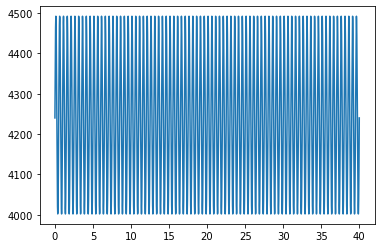

In [14]:
fs = 96000
T = 40
f_c = 4240
f_m = 2
t = np.arange(int(fs*T)+1)/fs
pi = np.pi
B = 0.1667 # (bandwidth)
mod = (2**(B/2 * np.sin(2*pi*f_m*t)))
mod[-1] = mod[0]
y = mod*f_c
plt.plot(t, y)

from scipy.interpolate import CubicSpline

cs = CubicSpline(t,y, extrapolate='periodic',bc_type='periodic')
# y2 = cs(t)
# plt.plot(t, y2)
cs2 = cs.antiderivative() # integrate to get time
# plt.plot(t, cs2(t))

sound = np.cos(2*pi*cs2(t))

In [22]:
math.exp(math.log(2)*4)

15.999999999999998

In [15]:
mod[0], mod[-1]

(1.0, 1.0)

In [16]:
s1 = sound[0]
print( (np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1])) # It's not periodic!
idx = np.argmin((np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1]))
print(idx, min((np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1])))

[2.29578111e+01 5.15016071e+01 3.54889364e+01 3.04901373e+00
 1.11685566e+01 4.55840878e+01 4.58383688e+01 1.14847083e+01
 2.87165698e+00 3.51296305e+01 5.15915396e+01 2.33390000e+01
 2.81645958e-03 2.25773061e+01 5.14062079e+01 3.58462318e+01
 3.23134943e+00 1.08556247e+01 4.53256101e+01 4.60884103e+01
 1.18040259e+01 2.69930976e+00 3.47683772e+01 5.16759887e+01
 2.37208023e+01 1.12655308e-02 2.21975585e+01 5.13053602e+01
 3.62014413e+01 3.41862477e+00 1.05459839e+01 4.50630043e+01
 4.63341368e+01 1.21264014e+01 2.53203550e+00 3.44053239e+01
 5.17549187e+01 2.41030359e+01 2.53408593e-02 2.18187746e+01
 5.11991251e+01 3.65543526e+01 3.61071866e+00 1.02398317e+01
 4.47964242e+01 4.65754264e+01 1.24516908e+01 2.36989351e+00
 3.40405831e+01 5.18283140e+01 2.44856349e+01 4.50373724e-02
 2.14409681e+01 5.10875028e+01 3.69049999e+01 3.80765843e+00
 9.93710281e+00 4.45258261e+01 4.68123149e+01 1.27799272e+01
 2.21286962e+00 3.36741407e+01 5.18961789e+01 2.48686114e+01
 7.03550786e-02 2.106412

In [17]:
s1, sound[idx*int(fs/f_m) + int(3*fs/f_m/2)]

(1.0, 0.7634758107420823)

In [18]:
A_max = 2**15-1 # max amplitude (short)
num_channels = 1 # 1 = mono, 2 = stereo


filename='caleb_lsFM_96k_4.24k_2_0.1667.wav'
# filename='caleb_lsFM_96k_8.485k_8_5.wav'
with wave.open(os.path.join(output_dir, filename),'wb') as wf:
    # File settings
    wf.setnchannels(num_channels)
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)
    
    sound = (A_max*sound[:(idx+1)*int(fs/f_m)]).astype(np.int16)
#     sound = (A_max*sound[int(fs/f_m/2):idx*int(fs/f_m)+int(3*fs/f_m/2)]).astype(np.int16)
    
    # Write frames to file object
    for i in range(len(sound)):
        s = struct.pack('<h', sound[i]) # pack as short
        for j in range(num_channels):
            wf.writeframesraw(s)

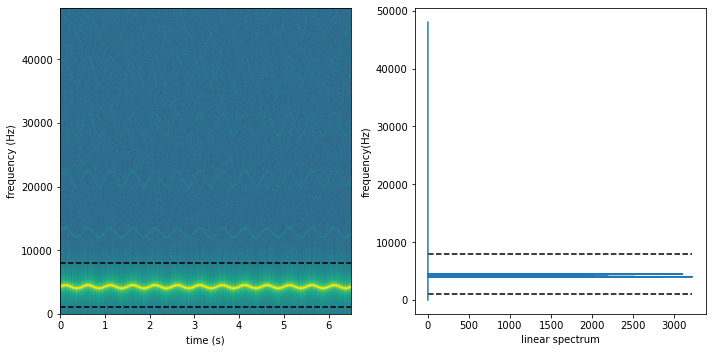

In [30]:
# Check characteristics of tone cloud
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
f_low = 1000
f_high = 8000
T = len(sound)/fs
# Plot spectrogram
ax[0].specgram(sound, Fs=int(fs), NFFT=1024)
ax[0].hlines((f_low, f_high), (0.0,)*2, (T,)*2, 
             color='black', linestyle='--')
ax[0].set_xlim([0.0, T])
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('frequency (Hz)')

# Plot PSD vs. frequency
freq, Pxx = signal.periodogram(sound, fs=fs, scaling='spectrum')
ax[1].plot(np.sqrt(Pxx[1:-1]), freq[1:-1])
ax[1].hlines((f_low, f_high), (0.0,)*2, (np.sqrt(Pxx[1:-1]).max(),)*2, 
             color='black', linestyle='--')
ax[1].set_xlabel('linear spectrum')
ax[1].set_ylabel('frequency(Hz)')

plt.tight_layout();

In [ ]:
fs = 96000
T = 40
f_c = 4240
f_m = 2
t = np.arange(int(fs*T)+1)/fs
pi = np.pi
B = 0.1667 # (bandwidth)
mod = (2**(B/2 * np.sin(2*pi*f_m*t)))
mod[-1] = mod[0]
y = mod*f_c
plt.plot(t, y)

from scipy.interpolate import CubicSpline

cs = CubicSpline(t,y, extrapolate='periodic',bc_type='periodic')
# y2 = cs(t)
# plt.plot(t, y2)
cs2 = cs.antiderivative() # integrate to get time
# plt.plot(t, cs2(t))

sound = np.cos(2*pi*cs2(t))

In [41]:
from scipy.interpolate import CubicSpline

def log_sine(fs = 96000.0, Tmax = 10, A=255,
             f_c = 4000, # carrier frequency
             f_m = 2, # frequency of modulator
             B = 1): # B is bandwidth in octaves
  t = np.arange(int(fs*Tmax)+1)/fs
  pi = np.pi
  mod = (2**(B/2 * np.sin(2*pi*f_m*t)))
  mod[-1] = mod[0] # force a 0 at the end
  y = mod*f_c

  cs = CubicSpline(t,y, extrapolate='periodic',bc_type='periodic')
  cs2 = cs.antiderivative() # integrate to get time

  sound = np.cos(2*pi*cs2(t))
  
  s1 = sound[0]
  idx = np.argmin((np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1]))

  n_loops = idx + 1
  error = min((np.abs(s1 - sound[int(fs/f_m)::int(fs/f_m)])) / (1-sound[1]))

  sound = (A*sound[:(idx+1)*int(fs/f_m)]).astype(np.int16)

  
  return sound, n_loops, error

In [43]:

# Audio settings
num_channels = 1 # 1 = mono, 2 = stereo
fs = 96000.0 # Hz
Tmax = 60.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 1.0*A_max # sample amplitude

prefix = 'lsFM_CK'

param_sets = [(12000, 2, 1/6), (12000, 8, 1/6), (4240, 2, 1/6), (4240, 8, 1/6), (8485, 2, 5), (8485, 8, 5)]

for p in param_sets:
  f_c = p[0]
  f_m = p[1]
  B = p[2]
  filename = '{}_{:.4g}k_{:.3g}_{:.4g}.wav'.format(prefix, f_c/1000, f_m, B)

  print(filename)
  with wave.open(os.path.join(output_dir, filename),'wb') as wf:
      # File settings
      wf.setnchannels(num_channels)
      wf.setsampwidth(2) # 2 bytes = short
      wf.setframerate(fs)

      # Create sound
      y, n_loops, error = log_sine(fs=fs, 
                     Tmax=Tmax, 
                     A=A,
                     f_c=f_c,
                     f_m=f_m,
                     B=B)
      y = y.astype(np.int16)

      # Write frames to file object
      for i in range(len(y)):
          s = struct.pack('<h', y[i]) # pack as short
          for j in range(num_channels):
              wf.writeframesraw(s)
              
  # Save sound parameters
  filename_json = '{}_{:.4g}k_{:.3g}_{:.4g}.json'.format(prefix, f_c/1000, f_m, B)

  with open(os.path.join(output_dir,filename_json), 'w') as f:
    d = {'num_channels': 2,
         'fs': fs, 
         'Tmax': Tmax,
         'A': A,
         'f_c': f_c,
         'f_m': f_m,
         'B': B,
         'n_loops': float(n_loops),
         'error': error}
    f.write(json.dumps(d, indent=4))

lsFM_CK_12k_2_0.1667.wav
lsFM_CK_12k_8_0.1667.wav
lsFM_CK_4.24k_2_0.1667.wav
lsFM_CK_4.24k_8_0.1667.wav
lsFM_CK_8.485k_2_5.wav
lsFM_CK_8.485k_8_5.wav
